In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
import time

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

# Functions

In [2]:
def dummies(df, list_cols):
    for col in list_cols:
        df_dummies = pd.get_dummies(df[col], drop_first=True, prefix=(str(col)))
        df = pd.concat([df, df_dummies], axis=1)
        df.drop(col, axis=1, inplace=True)
    return df

# Intro

The objective of the following exercise is to predict whether a patient will actually show up to medical appointment, given demographic data and pre-existing conditions.This dataset includes 10,527 medical appointment records from public health clinics in Brazil, collected between Nov 2015 and June of 2016. 

The features are socioeconomic and health condition characteristics of individuals. This dataset was collected by a private group and is available [here](https://www.kaggle.com/joniarroba/noshowappointments).

In [3]:
filepath = '/Users/wesamazaizeh/Desktop/Thinkful_Main_Course/Random_Forest_Models/Doctor_appt_no_show.csv'
aptmnt_df = pd.read_csv(filepath)
aptmnt_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


# Data cleaning & Feature engineering

In [4]:
# conver ScheduleDay and AppointmentDay to datetime
aptmnt_df.ScheduledDay = pd.to_datetime(aptmnt_df.ScheduledDay, format='%Y-%m-%dT%H:%M:%SZ')
aptmnt_df.AppointmentDay = pd.to_datetime(aptmnt_df.AppointmentDay, format='%Y-%m-%dT%H:%M:%SZ')

# fix negative waiting time by adding 23h59m59s
# extract appointment day of week, month, and waiting period before appointment data from datetime columns
aptmnt_df['AppointmentDay'] = aptmnt_df['AppointmentDay'] + pd.Timedelta('1d') - pd.Timedelta('1s')
aptmnt_df['Day_of_week'] = aptmnt_df.AppointmentDay.dt.day_name()
aptmnt_df['Month'] = aptmnt_df.AppointmentDay.dt.strftime('%b')
aptmnt_df['Wait_period'] = (aptmnt_df.AppointmentDay - aptmnt_df.ScheduledDay).dt.days

# eliminate negative waiting time data points
n_row = aptmnt_df.shape[0]
aptmnt_df = aptmnt_df.loc[aptmnt_df.Wait_period >= 0,:]
print('{} appoitments data were dropped'.format(n_row-aptmnt_df.shape[0]))



5 appoitments data were dropped


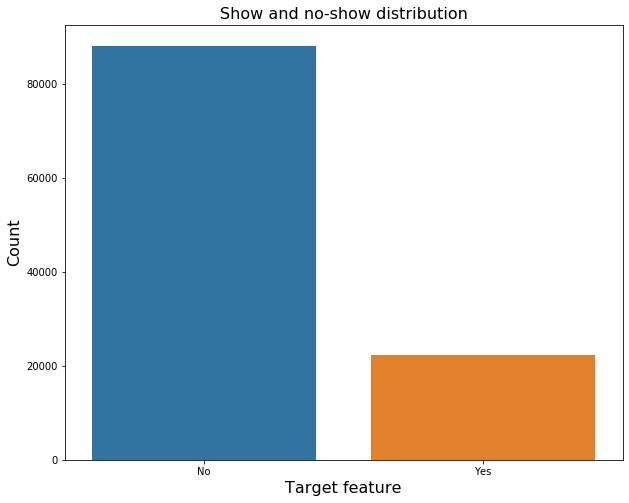

In [5]:
# visualizing target feature
plt.figure(figsize=(10,8))
sns.countplot(x='No-show', data=aptmnt_df)
plt.title('Show and no-show distribution', size=16)
plt.xlabel('Target feature', size=16)
plt.ylabel('Count', size=16)
# plt.legend(['No', 'Yes'])
plt.show()

# convert 'yes' 'no' to binary
aptmnt_df['No-show'] = aptmnt_df['No-show'].map(dict(Yes=1, No=0))

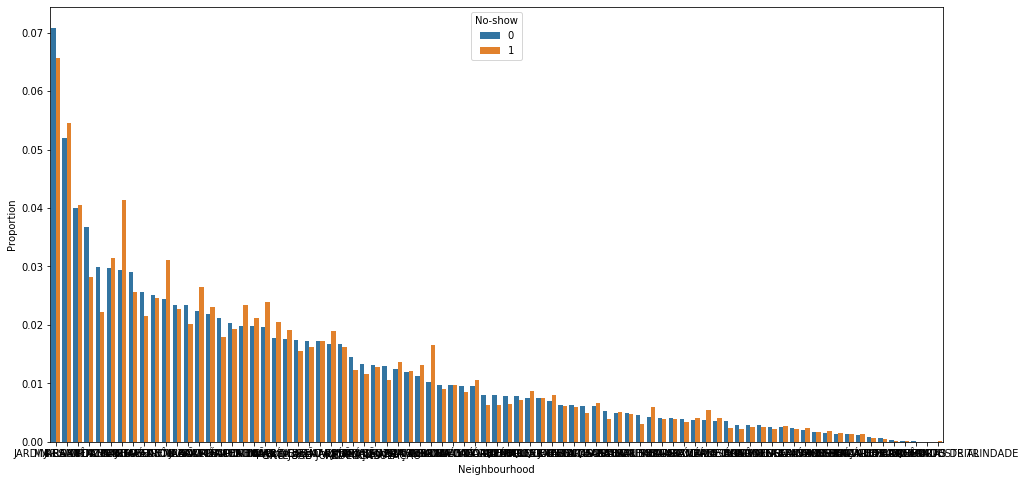

In [6]:
# does the neighborhood variable have an influence of no-show?
plt.figure(figsize=(16,8))
# sns.countplot(x='Neighbourhood', hue='No-show' ,data=aptmnt_df)

x, y, hue = "Neighbourhood", "Proportion", "No-show"
hue_order = ["No-show", "Show"]

(aptmnt_df[x]
 .groupby(aptmnt_df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

plt.show()

It seems that No-show and Show categories are equal for almost all neighborhoods. Will eliminate this information from further analysis

In [7]:
# drop neighborhood variable
aptmnt_df.drop('Neighbourhood', axis=1, inplace=True)

# get dummies of categorial variables
categorial = ['Gender', 'Day_of_week', 'Month']

aptmnt_df = dummies(aptmnt_df, list_cols=categorial)
aptmnt_df.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,...,No-show,Wait_period,Gender_M,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Month_Jun,Month_May
0,2.987250e+13,5642903,2016-04-29 18:38:08,2016-04-29 23:59:59,62,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.589978e+14,5642503,2016-04-29 16:08:27,2016-04-29 23:59:59,56,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,4.262962e+12,5642549,2016-04-29 16:19:04,2016-04-29 23:59:59,62,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8.679512e+11,5642828,2016-04-29 17:29:31,2016-04-29 23:59:59,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8.841186e+12,5642494,2016-04-29 16:07:23,2016-04-29 23:59:59,56,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# remove unnecessary PatientID and AppointmentID columns
aptmnt_df.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)

In [9]:
# use random forest classifier to idnetify most important features

data = aptmnt_df.drop(['No-show', 'AppointmentDay', 'ScheduledDay'], axis=1)
target = aptmnt_df['No-show']
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.2)

from sklearn.ensemble import RandomForestClassifier
feat_labels = data_train.columns
forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
forest.fit(data_train, target_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(data_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[f],importances[indices[f]]))

 1) Age                            0.462665
 2) Scholarship                    0.397766
 3) Hipertension                   0.023190
 4) Diabetes                       0.018188
 5) Alcoholism                     0.010924
 6) Handcap                        0.010795
 7) SMS_received                   0.010750
 8) Wait_period                    0.010110
 9) Gender_M                       0.009872
10) Day_of_week_Monday             0.009536
11) Day_of_week_Saturday           0.009414
12) Day_of_week_Thursday           0.008485
13) Day_of_week_Tuesday            0.007574
14) Day_of_week_Wednesday          0.005517
15) Month_Jun                      0.004927
16) Month_May                      0.000287


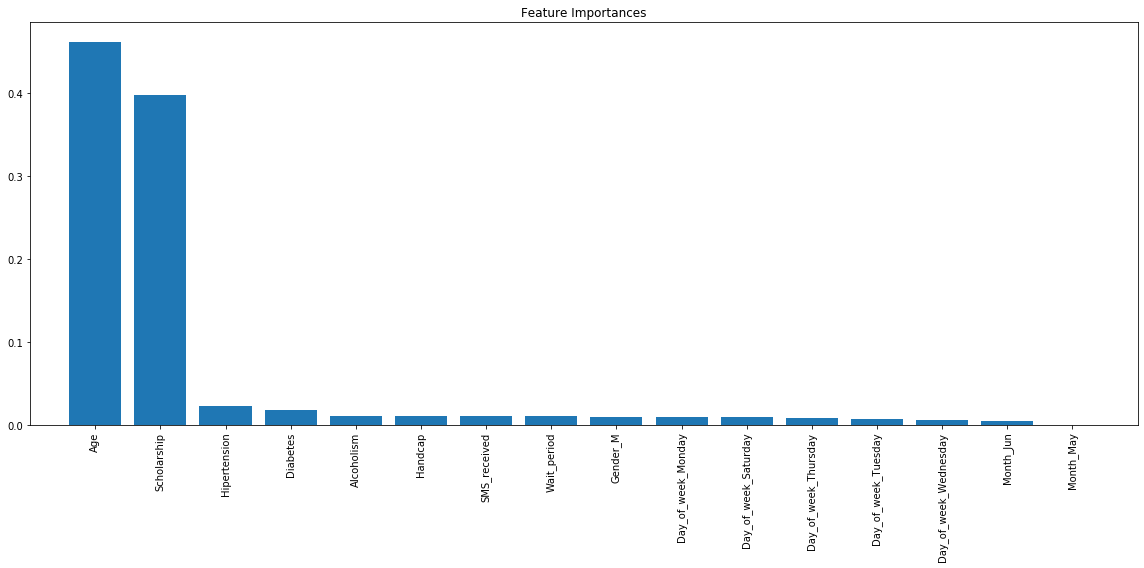

In [14]:
plt.figure(figsize=(16,8))
plt.title('Feature Importances')
plt.bar(range(data_train.shape[1]), importances[indices], align='center')
plt.xticks(range(data_train.shape[1]), feat_labels, rotation=90)
plt.xlim([-1, data_train.shape[1]])
plt.tight_layout()
plt.show()

It seems that Age and Scholarship account for almost 80% of the feature importance. Therefore, only these 2 features will be used for Decision Tree and Random Forest models

# Spliting and upsampling data

In [81]:
from sklearn.utils import resample

# prepare data with only Age and Scholarship data based on importance index from previous section
data = aptmnt_df.drop(['No-show', 'ScheduledDay', 'AppointmentDay'], axis=1)
target = aptmnt_df['No-show']

data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.2)

# upsample minority
X = pd.concat([data_train, target_train], axis=1)

# separate minority and majority classes
no_show = X[X['No-show']==0]
show = X[X['No-show']==1]

show_upsampled = resample(show,
                          replace=True, # sample with replacement
                          n_samples=len(no_show)) # match number in majority class

# combine majority and upsampled minority
upsampled = pd.concat([no_show, show_upsampled])

# check new class counts
print('Show Count\n',upsampled['No-show'].value_counts())

# reassigning balanced data
data_train = upsampled.drop('No-show', axis=1)
target_train = upsampled['No-show']

Show Count
 1    70601
0    70601
Name: No-show, dtype: int64


# Decision Tree

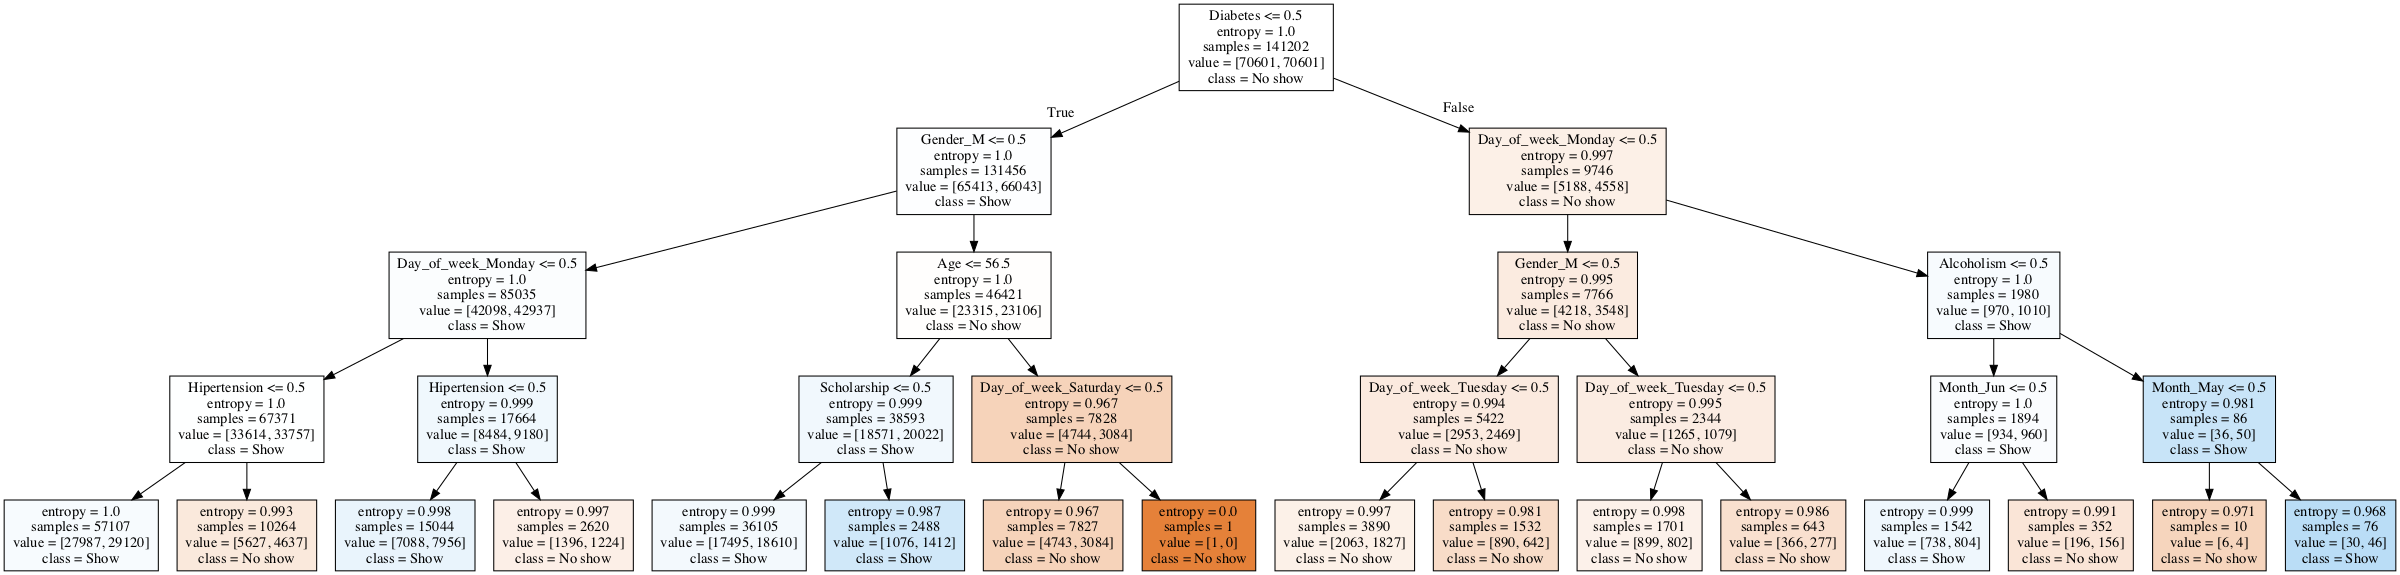

In [85]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4)

# fit model with timing
dt_time = time.time() # start timer
decision_tree.fit(data_train, target_train)
dt_time = time.time() - dt_time # end timer


# Render our tree
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=data_train.columns,
    class_names=['No show', 'Show'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_size('"25,25!"')
Image(graph.create_png())

In [86]:
print('Decision tree run time: {:.4f} seconds'.format(dt_time))
pred = decision_tree.predict(data_test)
print('Accuracy = {:.2f}'.format(metrics.accuracy_score(target_test, pred)))
print('F1 score = {:.2f}'.format(metrics.f1_score(target_test, pred)))
print('Recall score = {:.2f}'.format(metrics.recall_score(target_test, pred)))

Decision tree run time: 0.0811 seconds
Accuracy = 0.35
F1 score = 0.34
Recall score = 0.83


# Random Forest Model

In [87]:
rfc = ensemble.RandomForestClassifier()

rfc_time = time.time()
rfc = rfc.fit(data_train, target_train)
rfc_time = time.time() - rfc_time

print('Decision tree run time: {:.4f} seconds'.format(rfc_time))
pred = rfc.predict(data_test)
print('Accuracy = {:.2f}'.format(metrics.accuracy_score(target_test, pred)))
print('F1 score = {:.2f}'.format(metrics.f1_score(target_test, pred)))
print('Recall score = {:.2f}'.format(metrics.recall_score(target_test, pred)))

Decision tree run time: 2.5780 seconds
Accuracy = 0.71
F1 score = 0.34
Recall score = 0.38


Accuracies aren't so good. How can the model be improved?

How can features be selected confidently without having to run a heavy random forest classifier?

Would a regression model perform better?